In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
import pandas as pd
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob

In [2]:
project_id = "looker-assignment-113356033"
dataset_id = "final_project_dataset"

In [3]:
crendentials = service_account.Credentials.from_service_account_file(r"C:\nccu\workspace\dataModel_finalProjrct\looker-assignment-113356033-4959799503ac.json")

In [4]:
bigquery_client = bigquery.Client(project=project_id, credentials=crendentials)
storage_client = storage.Client(credentials=crendentials, project=project_id)

In [ ]:
# ============================
# 1. Data Loading and Preprocessing
# ============================
Bonk_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Bonk_top200_transactions`
"""

Bonk_transaction_data = bigquery_client.query(Bonk_query).to_dataframe()

FLOKI_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.FLOKI_top200_transactions`
"""

FLOKI_transaction_data = bigquery_client.query(FLOKI_query).to_dataframe()

Mog_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Mog_top200_transactions`
"""

Mog_transaction_data = bigquery_client.query(Mog_query).to_dataframe()

Pepe_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Pepe_top200_transactions`
"""

Pepe_transaction_data = bigquery_client.query(Pepe_query).to_dataframe()

Shib_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Shib_top200_transactions`
"""

Shib_transaction_data = bigquery_client.query(Shib_query).to_dataframe()

Bonk_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Bonk_top200_holders`
"""

Bonk_holders_data = bigquery_client.query(Bonk_query).to_dataframe()

FLOKI_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.FLOKI_top200_holders`
"""

FLOKI_holders_data = bigquery_client.query(FLOKI_query).to_dataframe()

Mog_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Mog_top200_holders`
"""

Mog_holders_data = bigquery_client.query(Mog_query).to_dataframe()

Pepe_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Pepe_top200_holders`
"""

Pepe_holders_data = bigquery_client.query(Pepe_query).to_dataframe()

Shib_query = """
SELECT
    *
FROM `looker-assignment-113356033.final_project_dataset.Shib_top200_holders`
"""

Shib_holders_data = bigquery_client.query(Shib_query).to_dataframe()

def load_and_preprocess_data(file_path):
    """
    Load transaction data and preprocess it.
    """
    #file_identifier = os.path.basename(file_path).split('_')[0]
    trans_df = pd.read_csv(file_path)
    trans_df['Date'] = pd.to_datetime(trans_df['timeStamp'], unit='s')
    #trans_df['tokenName'] = file_identifier
    trans_df['value'] = pd.to_numeric(trans_df['value'].str.replace(',', ''), errors='coerce')
    trans_df['year_month'] = trans_df['Date'].dt.strftime('%Y-%m')
    trans_df['year_month_day'] = trans_df['Date'].dt.strftime('%Y-%m-%d')
    # Ensure 'timeStamp' is a numeric type (if it's not already)
    trans_df['timeStamp'] = pd.to_numeric(trans_df['timeStamp'], errors='coerce')
    # Sort the DataFrame by 'timeStamp'
    trans_df = trans_df.sort_values(by='timeStamp', ascending=True).reset_index(drop=True)

    # Split into Buy and Sell
    sell_df = trans_df[['from', 'value', 'tokenName', 'year_month', 'year_month_day']].copy()
    sell_df.rename(columns={'from': 'Address'}, inplace=True)
    sell_df['Type'] = 'Sell'

    buy_df = trans_df[['to', 'value', 'tokenName', 'year_month', 'year_month_day']].copy()
    buy_df.rename(columns={'to': 'Address'}, inplace=True)
    buy_df['Type'] = 'Buy'

    transactions_df = pd.concat([sell_df, buy_df], ignore_index=True)
    print(f"[INFO] Data loaded and preprocessed: {transactions_df.shape[0]} rows from {file_identifier}")
    return transactions_df

def get_unique_year_month_labels(df, column='year_month'):
    """
    Extract unique 'year_month' values from a DataFrame and sort them.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'year_month' column.
        column (str): The name of the column containing year-month values.

    Returns:
        list: A sorted list of unique 'year_month' values.
    """
    if column not in df.columns:
        raise ValueError(f"[ERROR] Column '{column}' not found in the DataFrame.")

    # Extract unique values, drop NaNs, and sort
    unique_labels = sorted(df[column].dropna().unique())

    print(f"[INFO] Extracted {len(unique_labels)} unique 'year_month' labels.")
    return unique_labels

# ============================
# 2. Filter Transactions
# ============================
def filter_transactions_by_top_holders(transactions_df, top_holders_path):
    """
    Filter transactions to exclude exchange addresses and keep only Top 200 holder transactions.
    """
    exchange_df = pd.read_csv('data/exchange_addresses.csv')
    top_holders_df = pd.read_csv(top_holders_path)

    exchange_addresses = set(exchange_df['Address'].str.lower().str.strip())
    top_holder_addresses = set(top_holders_df['HolderAddress'].str.lower().str.strip())
    refined_holder_addresses = top_holder_addresses - exchange_addresses

    transactions_df['Address'] = transactions_df['Address'].str.lower().str.strip()
    filtered_transactions = transactions_df[transactions_df['Address'].isin(refined_holder_addresses)]

    print(f"[INFO] Filtered Transactions: {filtered_transactions.shape[0]} rows")
    return filtered_transactions

def remove_dead_addresses(transactions_df):
    """
    Remove rows where the 'Address' column contains the word 'dead'.

    Args:
        transactions_df (pd.DataFrame): The transactions DataFrame.

    Returns:
        pd.DataFrame: A filtered DataFrame without rows containing 'dead' in the 'Address' column.
    """
    if 'Address' not in transactions_df.columns:
        raise ValueError("[ERROR] Column 'Address' not found in the DataFrame.")

    # 確保 'Address' 欄位是字串型態，並移除包含 'dead' 的行（不區分大小寫）
    filtered_df = transactions_df[
        ~transactions_df['Address']
        .astype(str)      # 確保是字串型態
        .str.lower()      # 轉換為小寫
        .str.contains('dead', na=False)  # 篩選包含 'dead' 的行，忽略 NaN 值
    ]

    print(f"[INFO] Removed {transactions_df.shape[0] - filtered_df.shape[0]} rows containing 'dead' in 'Address'.")
    return filtered_df


# ============================
# 3. Data Aggregation
# ============================
def calculate_daily_flow(transactions_df):
    """
    Calculate daily buy, sell, and net flow volumes.
    """
    daily_flow = transactions_df.groupby(['year_month', 'Type'])['value'].sum().unstack(fill_value=0)
    daily_flow['Net Flow'] = daily_flow.get('Buy', 0) - daily_flow.get('Sell', 0)
    return daily_flow

def calculate_daily_frequency(transactions_df):
    """
    Calculate daily transaction frequency.
    """
    daily_frequency = transactions_df.groupby(['year_month', 'Type']).size().unstack(fill_value=0)
    daily_frequency['Total Transactions'] = daily_frequency.sum(axis=1)
    return daily_frequency

def align_data_with_xlabels(df, x_labels):
    """
    Align DataFrame with predefined x_labels.

    Args:
        df (pd.DataFrame): The DataFrame containing data to plot.
        x_labels (list): Predefined x-axis labels (year-month).

    Returns:
        pd.DataFrame: Aligned DataFrame matching x_labels.
    """
    # Ensure 'year_month' is the index
    # df = df.set_index('year_month')
    df = df.reindex(x_labels, fill_value=0)  # Fill missing x_labels with 0
    return df

# ============================
# 4. Visualization Functions
# ============================

def plot_combined_daily_flow(daily_flows, x_labels):
    """
    Plot daily buy, sell, and net flow for multiple datasets on the same plot,
    with straight x-axis labels.
    """
    plt.figure(figsize=(14, 8))

    # Ensure the same x-axis range for all datasets
    x_range = range(len(x_labels))

    for token, df in daily_flows.items():
        print(df.columns, df.head())
        df = align_data_with_xlabels(df, x_labels)
        plt.plot(df.index, df['Net Flow'], marker='o', linestyle='-', label=f'{token} Net Flow')

    plt.title('Combined Monthly Net Flow Across Tokens')
    plt.xlabel('Year-Month')
    plt.ylabel('Net Flow')
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()

    plt.xticks(x_range, x_labels, rotation=45, ha='right')  # Rotate slightly for clarity

    #save_plot('combined_daily_flow', 'net_flow')
    plt.show()


def plot_combined_daily_frequency(daily_frequencies, x_labels):
    """
    Plot daily transaction frequency for multiple datasets.
    """
    plt.figure(figsize=(14, 8))

    # Ensure the same x-axis range for all datasets
    x_range = range(len(x_labels))

    for token, df in daily_frequencies.items():
        df = align_data_with_xlabels(df, x_labels)
        plt.plot(df.index, df['Total Transactions'], marker='o', linestyle='-', label=f'{token} Transactions')

    plt.title('Combined Monthly Transaction Frequency Across Tokens')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Transactions')
    plt.legend()

    plt.xticks(x_range, x_labels, rotation=45, ha='right')  # Rotate slightly for clarity

    #save_plot('combined_daily_frequency', 'transaction_frequency')
    plt.show()

def plot_daily_flow_by_type(daily_flows, x_labels):
    """
    將每日 Buy 與 Sell 流量合併在同一張圖表中顯示，分別使用不同顏色進行區分。

    Args:
        daily_flows (dict): 包含多個 Token 每日流量 DataFrame 的字典。
        x_labels (list): 一個唯一的 'year_month' 標籤列表，用於對齊 x 軸。
    """
    plt.figure(figsize=(14, 8))

    for token, df in daily_flows.items():
        # 對齊 x_labels，確保所有 Token 的數據對齊
        df = align_data_with_xlabels(df, x_labels)

        # 繪製 Buy Flow
        if 'Buy' in df.columns:
            plt.plot(df.index, df['Buy'], marker='o', linestyle='-', label=f'{token} Buy Flow')

        # 繪製 Sell Flow
        if 'Sell' in df.columns:
            plt.plot(df.index, df['Sell'], marker='x', linestyle='--', label=f'{token} Sell Flow')

    # 圖表標題與標籤
    plt.title('Monthly Buy and Sell Flow Across Tokens')
    plt.xlabel('Year-Month')
    plt.ylabel('Flow Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)

    # 儲存圖表
    save_plot('combined_daily_flow_by_type', 'combined_buy_sell_flow')
    plt.show()

import matplotlib.pyplot as plt

def plot_daily_flow_with_price(daily_flows, pepe_price_df, x_labels):
    """
    將每日 Buy 與 Sell 流量，以及 PEPE 幣價 (Date 和 Close) 整合到同一個圖表中顯示。

    Args:
        daily_flows (dict): 包含多個 Token 每日流量 DataFrame 的字典。
        pepe_price_df (pd.DataFrame): PEPE 幣價 DataFrame，包含 Date 和 Close 欄位。
        x_labels (list): 唯一的 'year_month' 標籤列表，用於對齊 x 軸。
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # 繪製 Buy Flow 和 Sell Flow（主 Y 軸）
    for token, df in daily_flows.items():
        # 對齊 x_labels，確保所有 Token 的數據對齊
        df = align_data_with_xlabels(df, x_labels)

        if 'Buy' in df.columns:
            ax1.plot(df.index, df['Buy'], marker='o', linestyle='-', label=f'{token} Buy Flow')

        if 'Sell' in df.columns:
            ax1.plot(df.index, df['Sell'], marker='x', linestyle='--', label=f'{token} Sell Flow')

    ax1.set_xlabel('Year-Month')
    ax1.set_ylabel('Flow Value')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)

    # 繪製 PEPE 幣價（次 Y 軸）
    ax2 = ax1.twinx()
    pepe_price_df = pepe_price_df.set_index('Date').reindex(x_labels).fillna(method='ffill')

    ax2.plot(pepe_price_df.index, pepe_price_df['Close'], color='purple', marker='s', linestyle='-', label='PEPE Close Price')
    ax2.set_ylabel('PEPE Close Price')
    ax2.legend(loc='upper right')

    plt.title('Buy/Sell Flow and PEPE Close Price Trend')
    #save_plot('daily_flow_with_price', 'buy_sell_flow_with_price')
    plt.show()

# ============================
# 5. Save Plots
# ============================
def save_plot(file_name, plot_type, output_dir='plots'):
    """
    Save the current plot to a specified directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plot_file_name = f"{file_name}_{plot_type}.png"
    plot_path = os.path.join(output_dir, plot_file_name)
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"[INFO] Plot saved: {plot_path}")
    plt.close()

# ============================
# 6. Main Function
# ============================
def main():
    # 定義交易和持有者資料的字典
    file_dict = {
        "Bonk": Bonk_transaction_data,
        "FLOKI": FLOKI_transaction_data,
        "Mog": Mog_transaction_data,
        "Pepe": Pepe_transaction_data,
        "Shib": Shib_transaction_data
    }

    holder_dict = {
        "Bonk": Bonk_holders_data,
        "FLOKI": FLOKI_holders_data,
        "Mog": Mog_holders_data,
        "Pepe": Pepe_holders_data,
        "Shib": Shib_holders_data
    }

    price_path = 'data/PEPE value.csv'
    price_df = pd.read_csv(price_path)
    pepe_price_df =  extract_monthly_first_close(price_df)

    # 初始化結果字典
    daily_flows = {}
    daily_frequencies = {}
    all_year_months = set()  # 用於存儲所有的 year_month 標籤

    # 處理每個 token
    for token, trans_path in file_dict.items():
        holder_path = holder_dict[token]  # 獲取對應的持有者檔案路徑

        # 使用 token 作為 file_identifier
        trans_df = load_and_preprocess_data(trans_path)
        transactions_df = filter_transactions_by_top_holders(trans_df, holder_path)
        transactions_df = remove_dead_addresses(transactions_df)
        
        # 提取所有 year_month 值
        all_year_months.update(trans_df['year_month'].unique())

        # 計算 daily flow 和 daily frequency
        daily_flows[token] = calculate_daily_flow(transactions_df)
        daily_frequencies[token] = calculate_daily_frequency(transactions_df)

     # 生成完整的時間標籤列表，按時間排序
    x_labels = sorted(all_year_months)
    
    # Plot combined results
    plot_combined_daily_flow(daily_flows, x_labels)
    plot_combined_daily_frequency(daily_frequencies, x_labels)
    plot_daily_flow_with_price(daily_flows, pepe_price_df, x_labels)


[INFO] 提取了 20 條每月1號的數據。


C:\Users\JIN\AppData\Local\Temp\ipykernel_458444\1872442733.py:13: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_df = pd.read_csv(file_path)


[INFO] Data loaded and preprocessed: 1241762 rows from pepe
[INFO] Filtered Transactions: 288086 rows
[INFO] Removed 38359 rows containing 'dead' in 'Address'.


C:\Users\JIN\AppData\Local\Temp\ipykernel_458444\1872442733.py:13: DtypeWarning: Columns (8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_df = pd.read_csv(file_path)


[INFO] Data loaded and preprocessed: 1241762 rows from pepe
[INFO] Extracted 21 unique 'year_month' labels.
Index(['Buy', 'Sell', 'Net Flow'], dtype='object', name='Type') Type                 Buy          Sell      Net Flow
year_month                                          
2023-04     8.580162e+22  8.835071e+22 -2.549095e+21
2023-05     1.237784e+24  8.867934e+23  3.509909e+23
2023-06     3.746009e+24  2.409179e+24  1.336831e+24
2023-07     1.235466e+23  1.476686e+23 -2.412204e+22
2023-08     9.849082e+22  1.011799e+23 -2.689128e+21


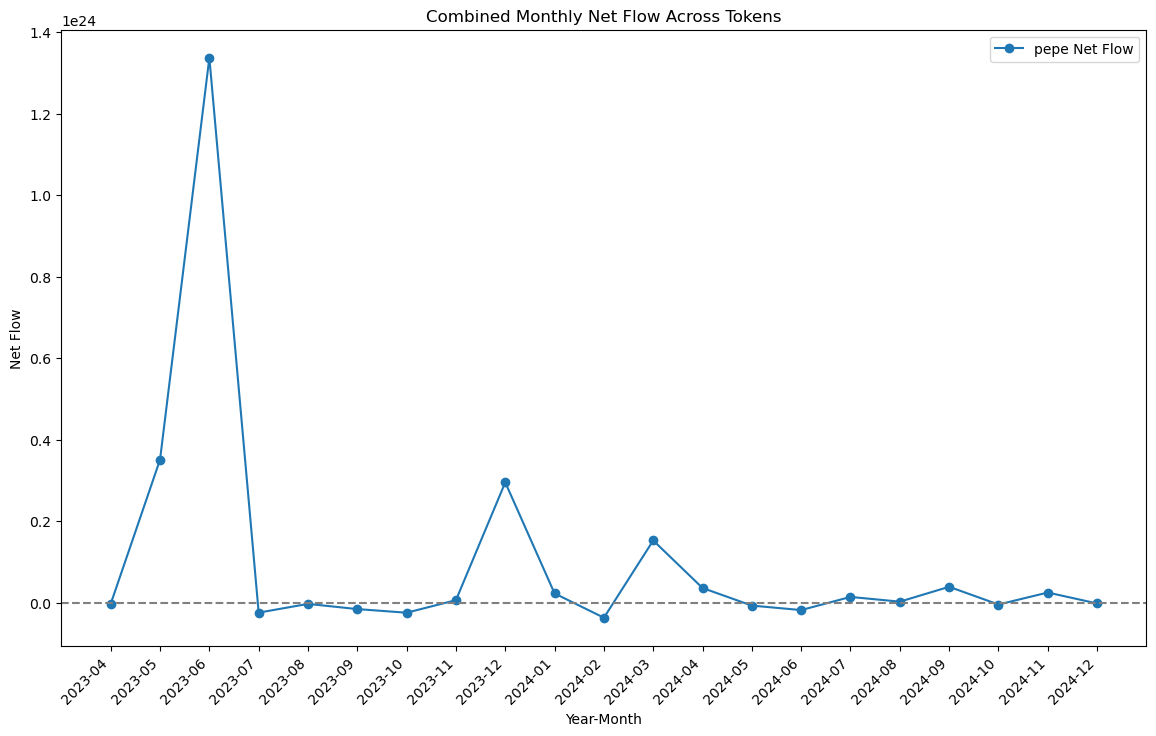

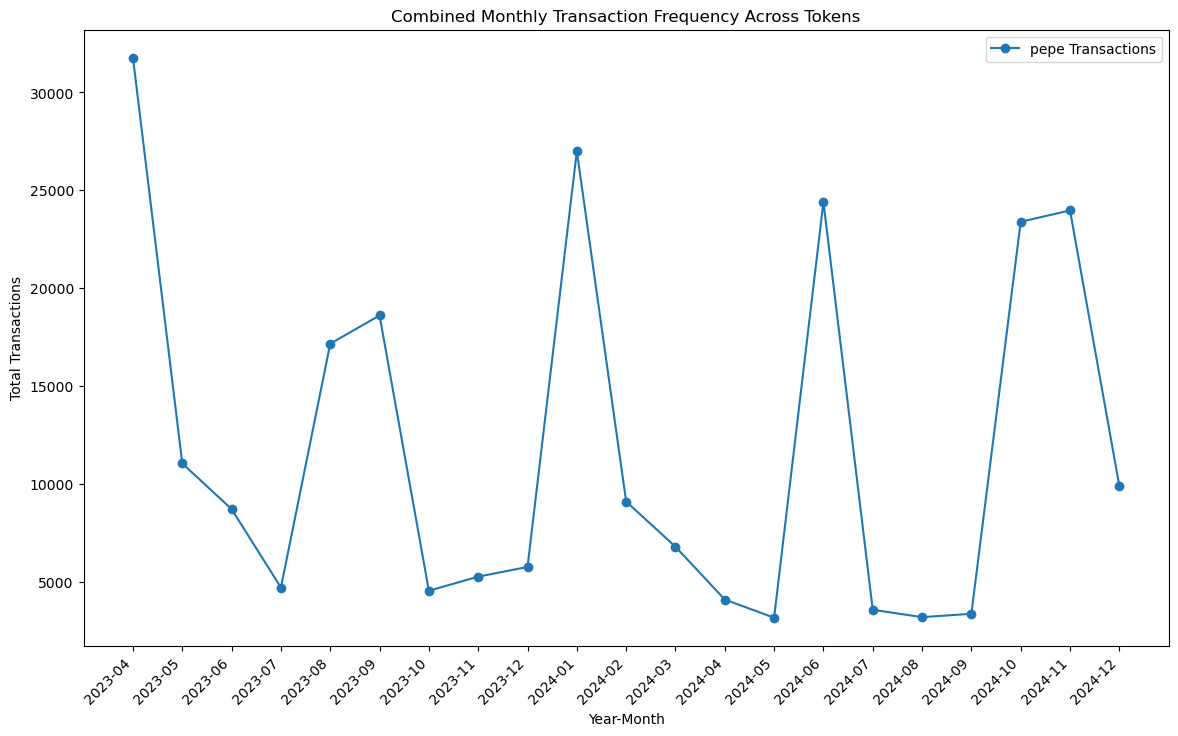

C:\Users\JIN\AppData\Local\Temp\ipykernel_458444\1872442733.py:257: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pepe_price_df = pepe_price_df.set_index('Date').reindex(x_labels).fillna(method='ffill')


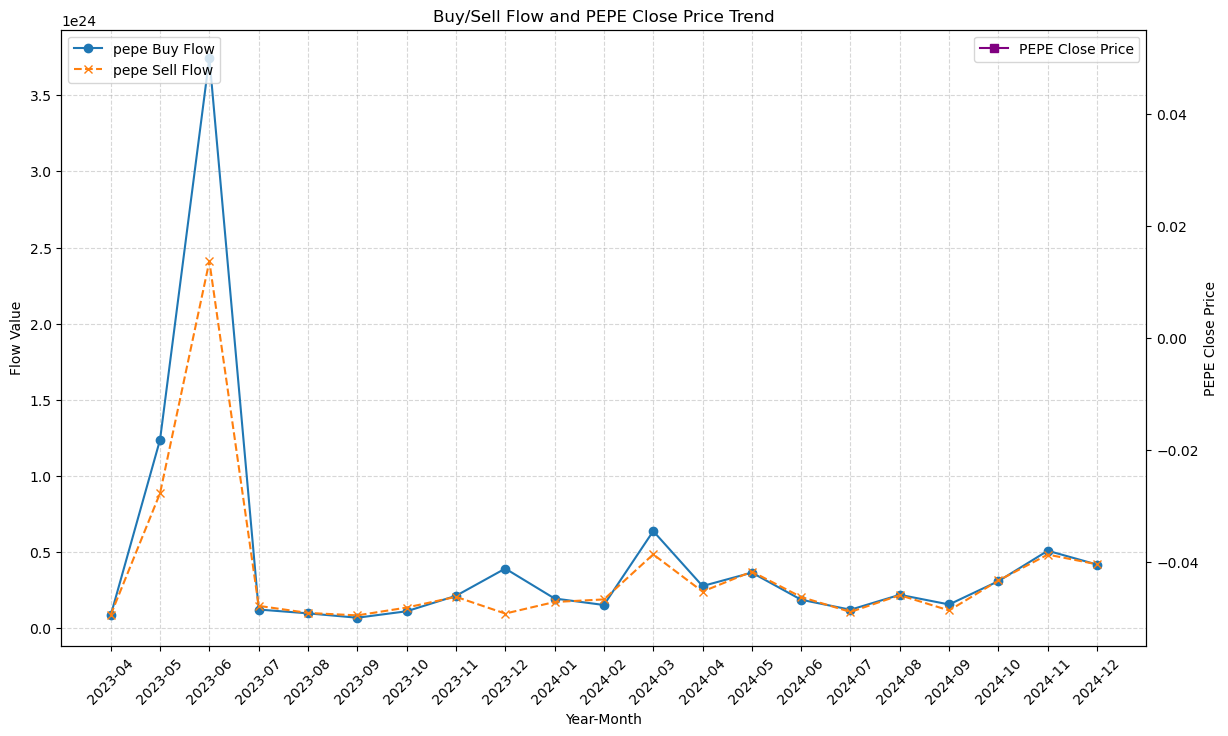

In [ ]:
# ============================
# Entry Point
# ============================
if __name__ == '__main__':
    main()

In [ ]:
import pandas as pd

def extract_monthly_first_close(dataframe):
    """
    從 PEPE 幣價 DataFrame 中提取每月1號的 Date 和 Close 資料。

    Args:
        dataframe (pd.DataFrame): 包含 Date 和 Close 欄位的 DataFrame。

    Returns:
        pd.DataFrame: 包含每月1號的 Date 和 Close 欄位的篩選後 DataFrame。
    """
    # 確保 'Date' 欄位是 datetime 格式
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], errors='coerce')

    # 移除無效日期的行
    dataframe = dataframe.dropna(subset=['Date'])

    # 提取每月1號的數據
    monthly_first_df = dataframe[dataframe['Date'].dt.day == 1]

    # 選取 Date 和 Close 欄位
    result = monthly_first_df[['Date', 'Close']].reset_index(drop=True)

    print(f"[INFO] 提取了 {result.shape[0]} 條每月1號的數據。")
    return result
